In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

In [2]:
df = pd.read_csv('data/snsdata.csv')
df.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


In [3]:
# оставим только признаки интересов подростков(ключевые слова)
df.drop(['gradyear', 'gender', 'age', 'friends'], inplace=True, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 36 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   basketball    30000 non-null  int64
 1   football      30000 non-null  int64
 2   soccer        30000 non-null  int64
 3   softball      30000 non-null  int64
 4   volleyball    30000 non-null  int64
 5   swimming      30000 non-null  int64
 6   cheerleading  30000 non-null  int64
 7   baseball      30000 non-null  int64
 8   tennis        30000 non-null  int64
 9   sports        30000 non-null  int64
 10  cute          30000 non-null  int64
 11  sex           30000 non-null  int64
 12  sexy          30000 non-null  int64
 13  hot           30000 non-null  int64
 14  kissed        30000 non-null  int64
 15  dance         30000 non-null  int64
 16  band          30000 non-null  int64
 17  marching      30000 non-null  int64
 18  music         30000 non-null  int64
 19  rock          30000 non-n

#### StandardScaler()

In [4]:
# Нормализуем данные 
scaler = StandardScaler()
X_norm = scaler.fit_transform(df)
display(round(X_norm[0][0],2))



-0.33

#### KMeans

In [5]:
# Строим модель KMeans
model = KMeans(
    n_clusters=9,
    random_state=42
    
)
model.fit(X_norm)
display(round(model.inertia_,2))

857169.1

In [6]:
# Узнаём сколько подростков относится к кластерам 
df.loc[:,'label'] = model.labels_
df.label.value_counts()

label
0    19659
3     4490
7     2098
1      930
4      851
6      762
8      716
5      493
2        1
Name: count, dtype: int64

In [7]:
# 2 Способ 
#from collections import Counter
#cluster_counts = Counter(model.labels_)

# Узнаём сколько подростков относится к наиболее многочисленному кластеру
#most_numerous_cluster = max(cluster_counts, key=cluster_counts.get)
#teenagers_in_most_numerous_cluster = cluster_counts[most_numerous_cluster]
# Узнаём сколько подростков относится к самому малочисленному
#least_numerous_cluster = min(cluster_counts, key=cluster_counts.get)
#teenagers_in_least_numerous_cluster = cluster_counts[least_numerous_cluster]

#print(f"\nКоличество подростков в наиболее многочисленном кластере: {teenagers_in_most_numerous_cluster}")
#print(f"Количество подростков в наименее многочисленном кластере: {teenagers_in_least_numerous_cluster}")

#### Метод локтя

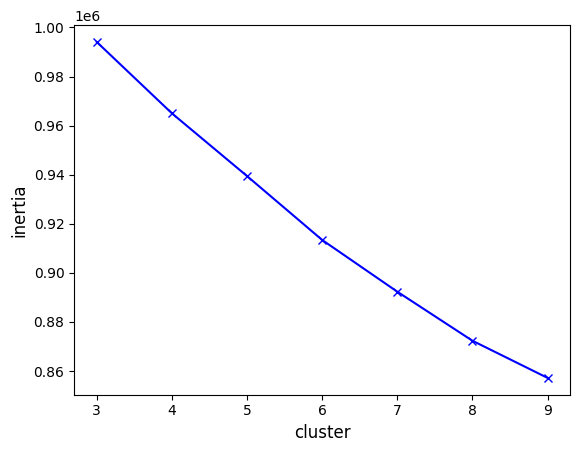

In [8]:

# функция, которая принимает количество кластеров для k-means и матрицу с признаками объектов и возвращает инерцию 
def get_inertia(cluster_num, X_norm):
# инициализируем алгоритм кластеризации
    k_means =  KMeans(n_clusters=cluster_num, random_state=42)
# запускаем алгоритм k-means
    k_means.fit(X_norm)
# находим значение инерции
    inertia = k_means.inertia_
# возвращаем значение инерции
    return inertia

# создаём пустой список для значений инерции
inertia = []
# итерируемся по разным размерам кластеров (от 3 до 9) и сохраняем значение инерции для каждого кластера
for cluster_num in range(3, 10):
# сохраняем значения
    inertia.append(get_inertia(cluster_num, X_norm))

# визуализируем, как менялась инерция в зависимости от количества кластеров
# задаём названия осям x и y
plt.xlabel("cluster", fontsize=12)
plt.ylabel("inertia", fontsize=12)
# рисуем изменение инерции
plt.plot([i for i in range(3, 10)], inertia, 'xb-')

#### Коэффициент силуэта

<Axes: xlabel='cluster', ylabel='silhouette'>

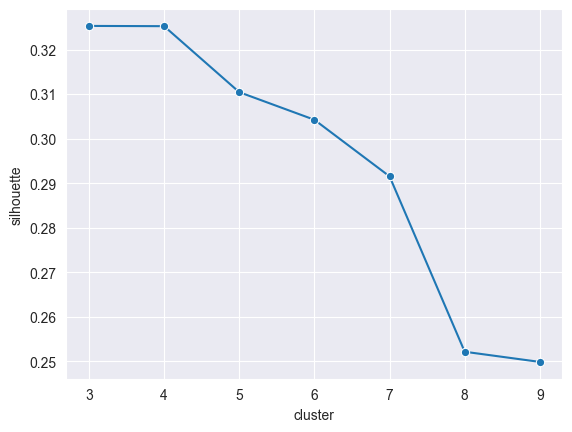

In [9]:
# напишем функцию, как и при подсчете метода локтя
def get_silhouette(cluster_num, X_norm):
    k_means =  KMeans(n_clusters=cluster_num, init='k-means++', n_init=10, random_state=42)
    k_means.fit(X_norm)
# подсчитаем метрику силуэта, передав данные и то, к каким кластерам относятся объекты
    silhouette = silhouette_score(X_norm, k_means.predict(X_norm))
    return silhouette

# создадим пустой словарь, ключами будут инерция и количество кластеров
silhouette_res = {"silhouette": [], "cluster": []}

for cluster_num in range(3, 10):
    silhouette_res["silhouette"].append(get_silhouette(cluster_num, X_norm))
    silhouette_res["cluster"].append(cluster_num)
    
# сохраним в датафрейм значение силуэта и количество кластеров
silhouette_df = pd.DataFrame(silhouette_res)

# установим стиль для визуализиции
sns.set_style("darkgrid")
# визуализируем зависимость значения инерции от количества кластеров
sns.lineplot(data=silhouette_df, x="cluster", y="silhouette", marker= "o")

#### Составляем топ 10 самых частых слов для каждого кластера

In [10]:
# Выполняем сегментацию подростков
model = KMeans(n_clusters=3, random_state=42)
model.fit(X_norm)
df.loc[:, 'label'] = model.labels_

from collections import Counter
k = 10

# Создайте список для хранения топ-10 слов для каждого кластера
top_words_list = []

for label, group in df.groupby('label'):
    # Вычислите среднее по каждому признаку и отсортируйте данные
    means = group.iloc[:, :-1].mean().sort_values(ascending=False)
    
    # Выделим топ-10 слов
    top_10_words = list(means.head(10).index)
    
    # Добавьте топ-10 слов в список
    top_words_list.append(top_10_words)
# Найдём пересечение топ-10 слов для каждого кластера
common_words = set.intersection(*map(set, top_words_list))

# Создадим Counter для каждого кластера
cluster_counters = [Counter(group.iloc[:, :-1].values.flatten()) for label, group in df.groupby('label')]

# Найдём слова, которые характерны для каждого кластера
cluster_specific_words = {label: [word for word in top_words if word in common_words] for label, top_words in zip(range(k), top_words_list)}

# Слова, которые характерны для каждого кластера
for label, words in cluster_specific_words.items():
    print(f"Cluster {label} Specific Words:")
    print(words)

Cluster 0 Specific Words:
['music', 'dance', 'god', 'hair']
Cluster 1 Specific Words:
['hair', 'music', 'god', 'dance']
Cluster 2 Specific Words:
['music', 'god', 'dance', 'hair']


In [11]:
# Ещё 1 способ 
#0
#df = pd.read_csv('data/snsdata.csv')

# ЗАДАНИЕ 4.1
#df = df.iloc[:, 4:]

# ЗАДАНИЕ 4.2
#from sklearn.preprocessing import StandardScaler
#X = df.values
#scaler = StandardScaler()
#scaler.fit(X)
#X_norm = scaler.transform(X)

# Выполняем сегментацию подростков
#model = KMeans(n_clusters=3, random_state=42)
#model.fit(X_norm)
#df.loc[:, 'label'] = model.labels_

#top_list = []
#for label, group in df.groupby('label'):
 #   means = group.iloc[:,:-1].mean().sort_values(ascending=False)
  #  top_5 = set(means.head(10).index)
   # top_list.append(top_5)

#set.intersection(*top_list)

#### EM-алгоритм

In [12]:
gm_clustering = GaussianMixture(n_components=3, random_state=42)

# обучаем модель 
gm_clustering.fit(X_norm)

# для матрицы X получаем предсказания, к какому кластеру принадлежат объекты
gm_prediction = gm_clustering.predict(X_norm)

print(np.unique(gm_prediction, return_counts=True))

(array([0, 1, 2]), array([23426,  6573,     1]))


В одном из кластеров оказался всего один человек. Давайте узнаем, что это за подросток и чем он(а) интересуется.

In [14]:
# Выбираем топ признаков увлечений для данноого подростка, принадлежащих кластеру с одним человеком
pd.set_option('display.max_columns', None)  # Отображение всех столбцов в выводе
person_solo = np.where(gm_prediction == 2)
sorted_df = df.iloc[person_solo].max().sort_values(ascending=False)
display(sorted_df)

blonde          327
sex              22
hair             12
god              10
drunk             6
death             6
die               6
dress             2
football          2
dance             1
rock              1
band              1
label             1
sexy              1
cute              1
clothes           1
swimming          1
jesus             1
shopping          0
mall              0
hollister         0
abercrombie       0
drugs             0
basketball        0
bible             0
church            0
marching          0
kissed            0
hot               0
sports            0
tennis            0
baseball          0
cheerleading      0
volleyball        0
softball          0
soccer            0
music             0
dtype: int64